[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/embeddings.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Embeddings

Word embeddings are a type of word representation that allows words to be represented as dense vectors in a continuous space. Word embeddings are learned from a large corpus of text and are able to capture the semantic relationships between words. Word embeddings are used in many natural language processing tasks, such as text classification, named entity recognition, and machine translation.

In this notebook, we use the existing [ELMo](https://tfhub.dev/google/elmo/3) (Embeddings from Language Models) system from TensorFlow Hub to get embeddings for individual words. ELMo is a deep contextualized word representation model trained on a large corpus of text. It uses a deep bidirectional (i.e., from start to end tokens and from end to start) LSTM network to learn the contextual representations of words in a sentence. ELMo embeddings are 1024-dimensional vectors for each word in a sentence.

To compute the similarity between two words, we can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between their ELMo embeddings.
Cosine similarity is a measure of similarity between two non-zero vectors, giving a value between -1 and 1. A value of 1 means the vectors are identical, 0 means they are orthogonal, and -1 means they are opposite. [Inner product](https://en.wikipedia.org/wiki/Dot_product) (a.k.a., dot product) between two vectors, which also measures similarity, has a scale that depends on the magnitude of the vectors, while cosine similarity is normalized by the product of the magnitudes of the vectors.

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/rnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.
    !cp {directory}/img/* img/.

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Load the ELMo model

We load the ELMo model from TensorFlow Hub.

In [2]:
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")

We define a `word_to_embedding` function that gets the ELMo embeddings for a word. The function receives a word as input and returns a 1024-dimensional embedding.

In [3]:
def word_to_embedding(word: str, elmo_model_p) -> np.ndarray:
    """
    Get the ELMo embeddings for a word.
    :param word: the word to get the embeddings for
    :param elmo_model_p: the ELMo model used
    :return: a 1024-dimensional vector (embedding) representing the word
    """
    # Get the ELMo embeddings for the word
    # signatures is a dictionary with the available signatures for the model (default, tokens, sequence), tf.constant converts the word to a tensor, and ['elmo'] gets the embeddings returned by the model
    word_embeddings = elmo_model_p.signatures['default'](tf.constant([word]))['elmo']
    # the shape of embeddings is (batch_size, num_tokens, embedding_dim) = (1, 1, 1024)
    return word_embeddings[0][0]

## Word similarity

Let's visualize the similarity between different words using ELMo embeddings. We define a list of word pairs, including related words, synonyms, and unrelated words. We calculate the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the embeddings of the words in each pair. Cosine similarity is a measure of similarity between two non-zero vectors, giving a value between -1 and 1. A value of 1 means the vectors are identical, 0 means they are orthogonal, and -1 means they are opposite.

Feel free to add more word pairs to the list and see how the similarity changes.

In [4]:
word_pairs = [
    # related words
    ("apple", "banana"), ("apple", "orange"), ("apple", "apple"), ("king", "queen"), ("red", "yellow"),
    # synonyms
    ("film", "movie"), ("car", "automobile"), ("big", "large"),
    # unrelated words
    ("king", "eat"), ("drink", "movie"),
]

for word_pair in word_pairs:
    # Get the ELMo embeddings for the words
    embeddings_pair = [word_to_embedding(word, elmo_model) for word in word_pair]
    # Calculate cosine similarity between the words
    similarity_score = cosine_similarity([embeddings_pair[0]], [embeddings_pair[1]])
    print(f"Cosine similarity between '{word_pair[0]}' and '{word_pair[1]}': {similarity_score[0][0]}")

Cosine similarity between 'apple' and 'banana': 0.6364566683769226
Cosine similarity between 'apple' and 'orange': 0.6067031621932983
Cosine similarity between 'apple' and 'apple': 1.0
Cosine similarity between 'king' and 'queen': 0.8033543229103088
Cosine similarity between 'red' and 'yellow': 0.7959626913070679
Cosine similarity between 'film' and 'movie': 0.9009907841682434
Cosine similarity between 'car' and 'automobile': 0.8173584938049316
Cosine similarity between 'big' and 'large': 0.8099021911621094
Cosine similarity between 'king' and 'eat': 0.18019330501556396
Cosine similarity between 'drink' and 'movie': 0.346871554851532


## 2D representation of word embeddings

The word embedding represents that an object (e.g., word) is embedded in a high-dimensional space. Besides words, embeddings can be computed for sentences, paragraphs, or even entire documents. Moreover, embeddings can be used to represent other types of objects, such as images, graphs, audio, video and more.

Since word embeddings are high-dimensional vectors, it is difficult to visualize them. However, we cas use a dimensionality reduction technique to reduce their dimensionality to 2D and visualize them. We use the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) dimensionality reduction algorithm to represent the words in 2D. 

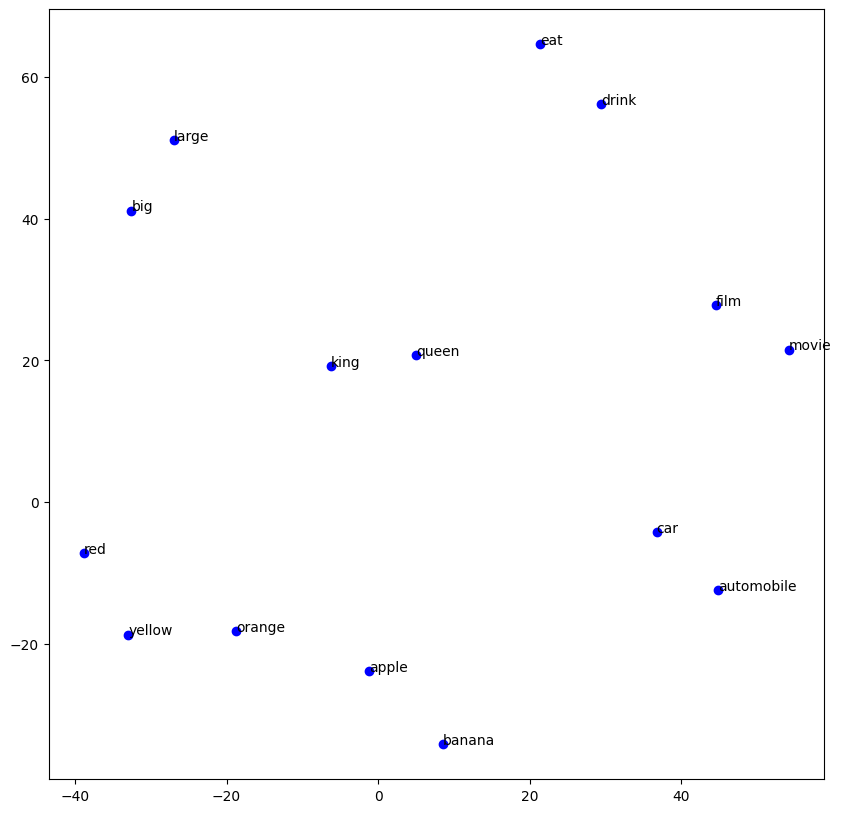

In [5]:
def visualize_embeddings(embeddings_p: np.array, words_p: list[str]) -> None:
    """
    Visualize the embeddings in 2D using t-SNE.
    :param embeddings_p: the embeddings to be visualized
    :param words_p: the words corresponding to the embeddings
    """
    tsne = TSNE(n_components=2, perplexity=5)
    embeddings_2d = tsne.fit_transform(embeddings_p)
    # Plot the 2D embeddings with scatter plot
    plt.figure(figsize=(10, 10))
    # plot the dots
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue')
    # plot each word close to the dot
    for i, word in enumerate(words_p):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.show()


# we take all the words from the word_pairs list
words = list(set([word for word_pair in word_pairs for word in word_pair]))
# Get the ELMo embeddings for all the words
embeddings = np.array([word_to_embedding(word, elmo_model) for word in words])
visualize_embeddings(embeddings, words)

## ✨ Questions ✨

1. Are related words closer in the 2D representation?
2. Are there any words close that you thought they would not be close?
3. Why do you think that is the case?

### Answers

*Write your answers here*
